# Introducción

Dentro de este proyecto se encuentra el análisis de cancelación al servicio que proporciona Model Fitness. El objetivo de tal análisis es identificar los factores que desencadenan una cancelación para así poder reducirlas.

Los datos que se usarán para esta tarea consisten en los perfiles de varios clientes. Los datos en cuestión son los siguientes:

- **Churn**: La cancelación para el mes en cuestión.
- Datos del usuario del mes anterior
    - **gender**: Género.
    - **Near_Location**: Si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
    - **Partner**: Si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
    - **Promo_friends**: si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
    - **Phone**: Si el/la usuario/a aportó el número de teléfono.
    - **Age**: Edad.
    - **Lifetime**: El tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.
- Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:
    - **Contract_period**: 1 mes, 3 meses, 6 meses o 1 año.
    - **Month_to_end_contract**: Los meses que faltan hasta que expire el contrato.
    - **Group_visits**: Si el/la usuario/a participa en sesiones grupales.
    - **Avg_class_frequency_total**: Frecuencia media de visitas por semana a lo largo de la vida del cliente.
    - **Avg_class_frequency_current_month**: Frecuencia media de visitas por semana durante el mes en curso.
    - **Avg_additional_charges_total**: Cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.

# Desarrollo

Importamos bibliotecas, declaramos funciones y establecemos el valor de la semilla para el estado aleatorio.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [30]:
def get_data(path: str) -> object:
    '''
    Store the data in a DataFrame.
    '''
    try:
        comp_path = "/" + path
        data = pd.read_csv(comp_path)
    except:
        comp_path = path
        data = pd.read_csv(comp_path)
    return data

In [31]:
def print_table(table: object) -> None:
    '''
    Print a table using display.
    '''
    try:
        display(table)
    except:
        print(table)

In [32]:
def show_means(data: object, features: list, categ: str) -> None:
    '''
    Prints the data's mean of a selected features.
    '''
    grupo = data.groupby(categ)

    caract_medias = {}

    for col in features:
        caract_medias[col] = grupo[col].mean()

    print_table(pd.DataFrame(caract_medias))

In [33]:
def show_performance(real: object, predicted: object) -> None:
    '''
    Prints accuracy, precision and recall scores from a model's predicted response. 
    '''
    metrics = "|| Exactitud: {:.4f} || Precision: {:.4f} || Recall: {:.4f} ||".format(
        accuracy_score(real, predicted),
        precision_score(real, predicted),
        recall_score(real, predicted)
    )
    print(metrics)

In [34]:
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (10,10))
    sns.scatterplot(data=df, x=x_name, y=y_name, 
                    hue = df[cluster_name], palette = 'Paired'
                    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [35]:
# Declaración de la semilla
seed = 137

## EDA

Cargamos datos y mostramos los primeros cinco registros.

In [36]:
data = get_data("datasets/gym_churn_us.csv")
print_table(data.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Imprimimos el estado de los datos.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

No hay datos nulos presentes. Se cambiará el tipo de dato del mes a entero, ya que este es flotante y el nombre de algunas columnas.

In [38]:
data["Month_to_end_contract"] = data["Month_to_end_contract"].astype(int)

data.columns = ['genero', 'ubicacion_cercana', 'client_asociado', 'promo_amigo', 'telefono_registrado', 'periodo_contratado', 'sesiones_grupales', 'edad', 'cargos_adicionales_tot', 'meses_faltantes', 'tiempo_de_vida', 'frec_asis_media_tot', 'frec_asis_media', 'cancelacion']

Mostramos los cambios.

In [39]:
data.info()
print("\n>> Columnas:\n")
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   genero                  4000 non-null   int64  
 1   ubicacion_cercana       4000 non-null   int64  
 2   client_asociado         4000 non-null   int64  
 3   promo_amigo             4000 non-null   int64  
 4   telefono_registrado     4000 non-null   int64  
 5   periodo_contratado      4000 non-null   int64  
 6   sesiones_grupales       4000 non-null   int64  
 7   edad                    4000 non-null   int64  
 8   cargos_adicionales_tot  4000 non-null   float64
 9   meses_faltantes         4000 non-null   int32  
 10  tiempo_de_vida          4000 non-null   int64  
 11  frec_asis_media_tot     4000 non-null   float64
 12  frec_asis_media         4000 non-null   float64
 13  cancelacion             4000 non-null   int64  
dtypes: float64(3), int32(1), int64(10)
memor

Ahora veamos algunas estadísticas.

In [40]:
print_table(data.describe())

,genero,ubicacion_cercana,client_asociado,promo_amigo,telefono_registrado,periodo_contratado,sesiones_grupales,edad,cargos_adicionales_tot,meses_faltantes,tiempo_de_vida,frec_asis_media_tot,frec_asis_media,cancelacion
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Aquí podemos ver que la edad promedio de los clientes es de 29 años, suelen asistir al rededor de dos veces por semana y el periodo de suscripción que suele ser más contratado es el de 3 o 6 meses.

Observemos ahora los valores medios de las personas que cancelaron y las que no. Comenzamos imprimiendo la distribución de los datos.

In [41]:
data_cancelados = data[data['cancelacion'] == 0]
data_vigentes = data[data['cancelacion'] == 1]

print(data_cancelados.shape)
print(data_vigentes.shape)

(2939, 14)
(1061, 14)


Dos de las terceras partes de los datos pertenecen a usuarios que no cancelaron su suscripción. Pasemos a observar las medias de cada grupo.

In [42]:
atributos = ['periodo_contratado', 'edad', 'cargos_adicionales_tot', 'meses_faltantes', 'tiempo_de_vida', 'frec_asis_media_tot', 'frec_asis_media']

show_means(data, atributos, 'cancelacion')

,periodo_contratado,edad,cargos_adicionales_tot,meses_faltantes,tiempo_de_vida,frec_asis_media_tot,frec_asis_media
cancelacion,,,,,,,
0,5.747193,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1.728558,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Desde este punto podemos observar que la frecuencia de visitas por semana baja a una semanal, el periodo contratado bajó a periodo de entre uno y tres meses. También es interesante observar que la media  en el tiempo de vida, bajó a uno.

Veamos gráficamente las métricas de los uusuarios de aquellos usarios que cancelaron el servicio.

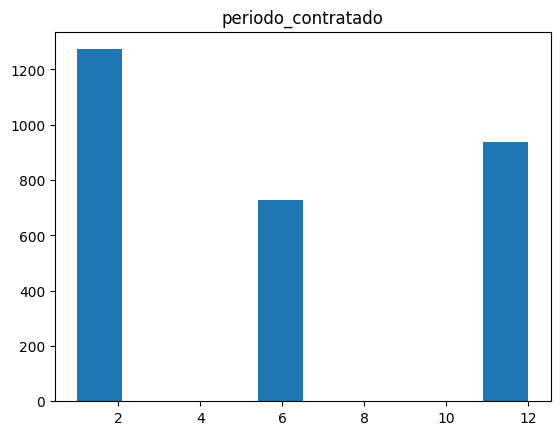

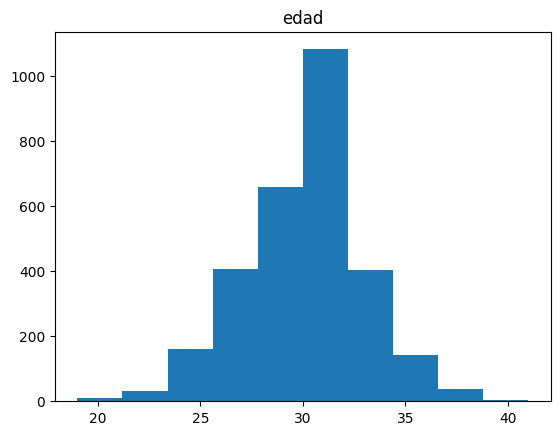

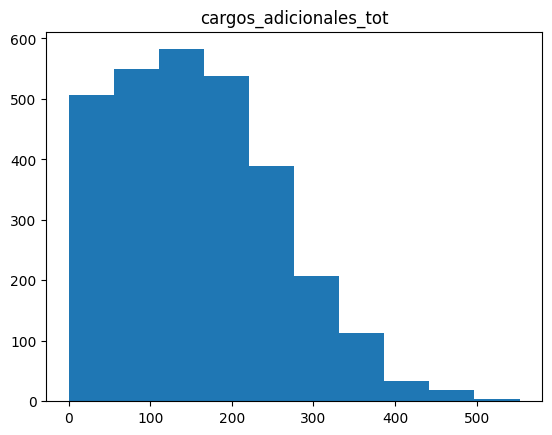

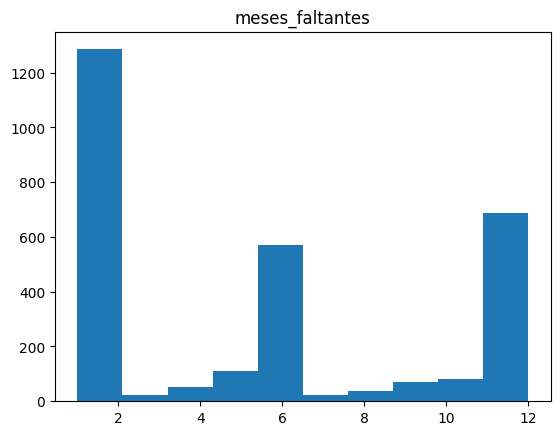

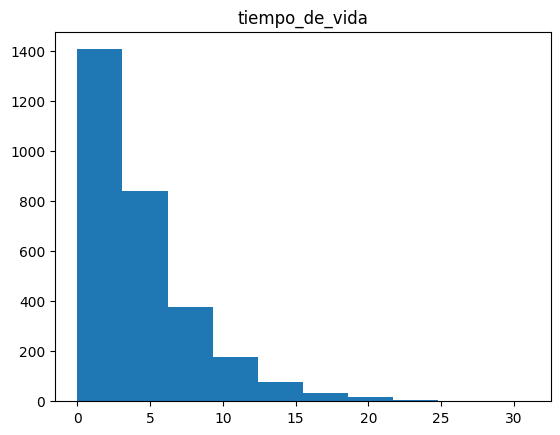

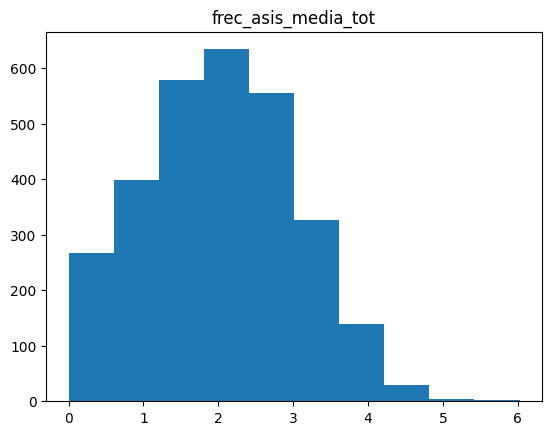

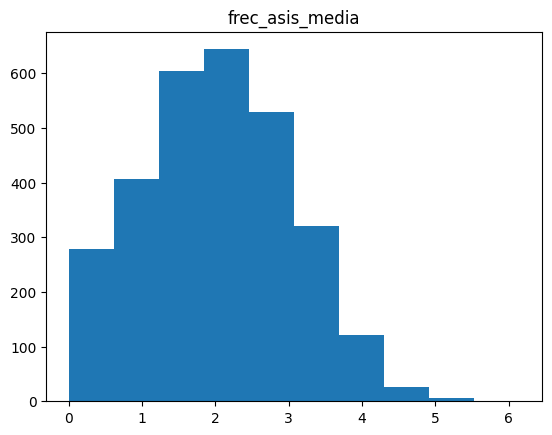

In [43]:
for col in atributos:
    plt.hist(data_cancelados[col])
    plt.title(col)
    plt.show()

Gracias a estos histogramas podemos observar que el periodo contratado está un poco más balanceado a como se pensó originalmente. Además, confirmamos que muchos de los usuarios llevan menos de 6 meses en el sistema y que la frecuencia de asistencia se mantiene en dos visitas por semana. Notamos también que la mayoría de personas que cancelan, lo hacen durante el primer mes del servicio, independientemente de la duración original que se contrató.

Veamos qué relación hay entre cada atributo.

<Axes: >

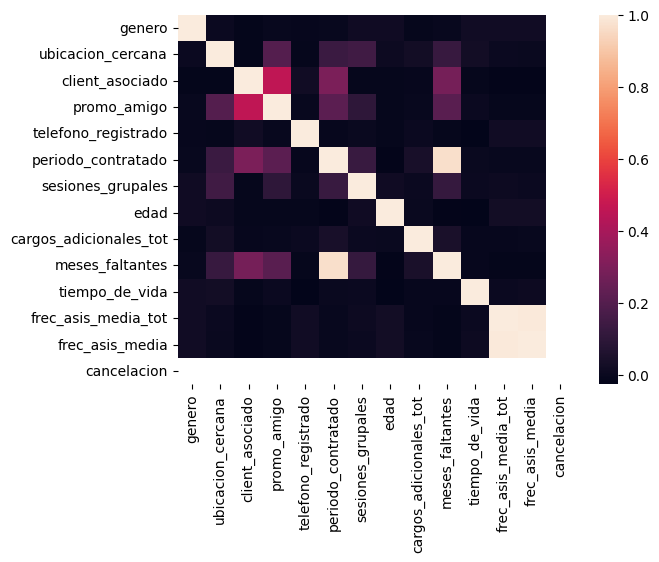

In [44]:
corr = data_cancelados.corr()

sns.heatmap(corr)

Aquí podemos observar la fuerte relación que hay entre los meses faltantes y el periodo contratado (los clientes suelen cancelar dentro del primer mes del servicio). Vemos también una relación significativa entre los clientes asociados y la promo amigo, lo que podría indicar que hay clientes que solo se registraron por el beneficio y lo que propició la cancelación prematura.

## Construcción del modelo

Comenzamos separando la variable objetivo de los datos.

In [45]:
x = data.drop(columns=['cancelacion'])
y = data['cancelacion']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=seed)

Antes de escalar los datos, separeremos los datos binarios del conjunto de entrenamiento y prueba.

In [46]:
bin_att = ['genero', 'ubicacion_cercana', 'client_asociado', 'promo_amigo', 'telefono_registrado', 'sesiones_grupales']
not_bin_att = ['periodo_contratado', 'edad', 'cargos_adicionales_tot', 'meses_faltantes', 'tiempo_de_vida', 'frec_asis_media_tot', 'frec_asis_media']

# Guardamos el index para la combinación posterior
x_train_index = x_train.index
x_test_index = x_test.index

x_train_nb = x_train.drop(columns=bin_att)
x_train_b = x_train.drop(columns=not_bin_att)

x_test_nb = x_test.drop(columns=bin_att)
x_test_b = x_test.drop(columns=not_bin_att)

Ahora cambiaremos la escala de los datos no binarios.

In [47]:
scaler = StandardScaler()

x_train_sc_nb = scaler.fit_transform(x_train_nb)
x_test_sc_nb = scaler.transform(x_test_nb)

Procedemos a combinar los datos binarios con los no binarios de ambos grupos.

In [48]:
# Conversión de un unmpy array a Data Frame
x_train_sc_nb = pd.DataFrame(x_train_sc_nb, index=x_train_index, columns=not_bin_att)
x_test_sc_nb = pd.DataFrame(x_test_sc_nb, index=x_test_index, columns=not_bin_att)

x_train_sc = pd.concat([x_train_b, x_train_sc_nb], axis=1)
x_test_sc = pd.concat([x_test_b, x_test_sc_nb], axis=1)

Veamos cómo se desempeña un modelo que usa la regresión logística para predecir las clases.

In [49]:
model = LogisticRegression(random_state=seed)
model.fit(x_train_sc, y_train)

y_pred = model.predict(x_test_sc)

show_performance(y_test, y_pred)

|| Exactitud: 0.9283 || Precision: 0.8976 || Recall: 0.8514 ||


Comparemos estos resultados con un modelo que use un bosque aleatorio.

In [50]:
model = RandomForestRegressor(random_state=seed)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_conv = np.where(y_pred > 0.5, 1 , 0)

show_performance(y_test, y_pred_conv)

|| Exactitud: 0.9200 || Precision: 0.9045 || Recall: 0.8114 ||


Los resultados y comportamiento de ambos modelos son muy similares. La regresión logística gana por un margen muy pequeño en la métrica de exactitud, sin embargo, al tener clases desbalanceadas, nos concentraremos en la métrica de presición, esto, debido a que no habrá repercusiones si se aplican medidas para prevenir la cancelación de un servicio si al final, el usuario no tenía pensado cancelar.

Dada esta métrica, se observa que random forest tiene ligeramente un mejor desempeño.

## Creación de clusters

Segementaremos ahora a nuestros clientes mediante clustering, para ello, comenzamos estandarizando los datos sin la columna que indica la cancelación del servicio.

In [51]:
x_sc = scaler.fit_transform(x)

Ahora crearemos una matriz de distancia para trazar un dendograma.

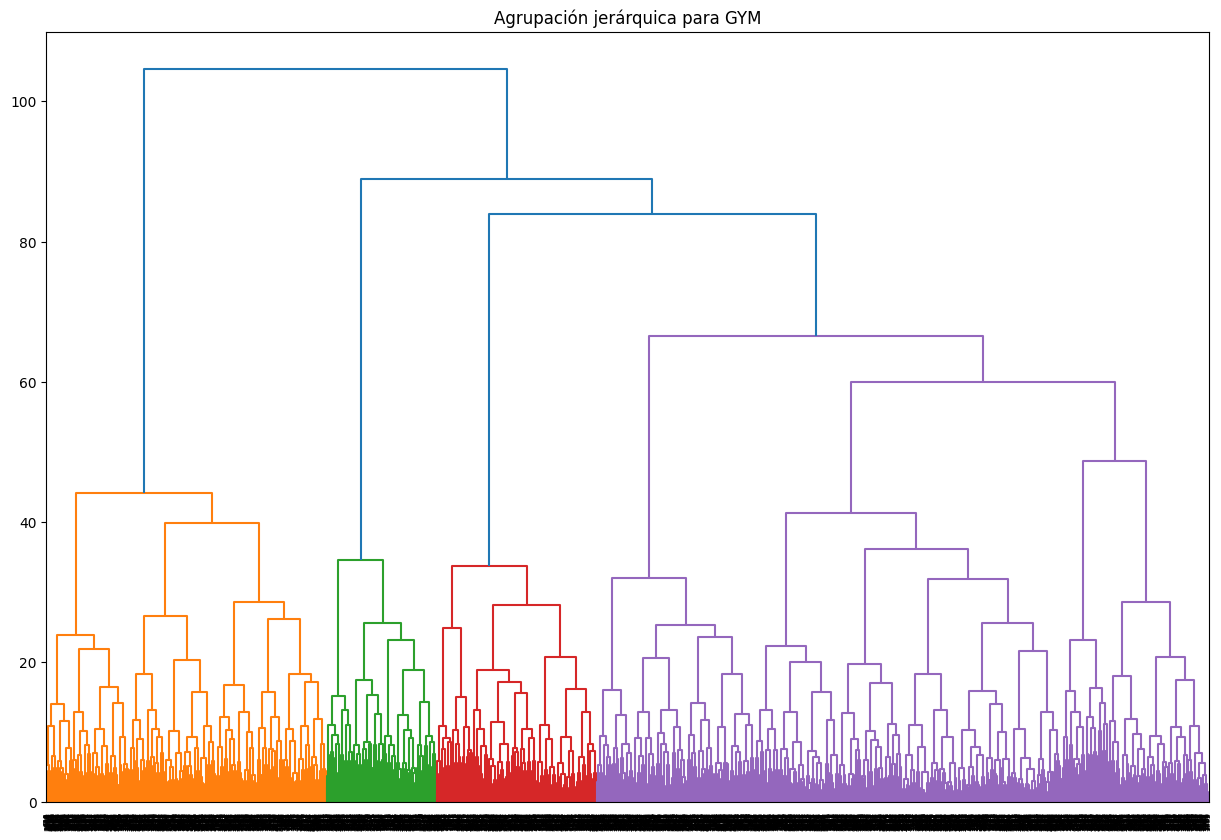

In [52]:
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Agrupación jerárquica para GYM')
plt.show()

Procedemos a usar el algoritmo de K-means, con 5 clusters. Note que aunque realizar los clusters con 6 grupos parece más natural, lo haremos con 5 debido a que al menos 3 grupos parece compartir muchas similitudes.

In [55]:
km = KMeans(n_clusters = 5, random_state=seed)
labels = km.fit_predict(x_sc)

data['cluster'] = labels

Examinemos los valores medios de cada cluster.

In [56]:
atributos.append('cancelacion')

show_means(data, atributos, 'cluster')

,periodo_contratado,edad,cargos_adicionales_tot,meses_faltantes,tiempo_de_vida,frec_asis_media_tot,frec_asis_media,cancelacion
cluster,,,,,,,,
0,2.885486,30.288948,163.197697,2.641811,5.178429,2.934272,2.939023,0.059920
1,2.214022,28.470480,133.676132,2.077491,2.774908,1.651012,1.459167,0.452030
2,1.999117,28.242049,131.023112,1.916078,2.477032,1.307771,1.073772,0.512367
3,3.066142,29.066142,140.042483,2.861417,3.533858,1.673250,1.555949,0.267717
4,11.859574,29.927660,165.442381,10.845745,4.742553,1.994342,1.985740,0.022340


De primera podemos ver que aquellos clusters que tienen menos cancelaciones (cero y cuatro) suelen gastar más en otros productos del gimnasio, así como también suelen ser los más longevos dentro del servicio. Esto es coherente, ya que son personas que independientemente del servicio, ya se han creado el hábito de asistir al gimnasio y/o tienen una meta para mejorar su estado físico. 

Es interesante observar que dentro de estos dos grupos el periodo contratado suele de ser de 12 meses en un grupo, mientras que el otro suele ser de 3 meses. Esto nos indica que el periodo contratado no influye mucho en la decisión de cancelación pero es una variable a considerar, ya que el grupo que contrata los 12 meses tiene un menor número de cancelaciones.

Los dos grupos que presentan una incidencia de cancelación más alta (uno y dos), por el contrario, gasta menos en productos extras, contratan menos tiempo, su longevidad dentro del servicio suele ser la menor y suelen ser los más jóvenes.

Con el cluster tres, que tiene una incidencia intermedia entre los clusters intermedios, tienen igualmente un valor intermedio de gastos adicionales, periodo de contratación y tiempo de vida.

Trazaremos ahora una distribución de características para los clusters.

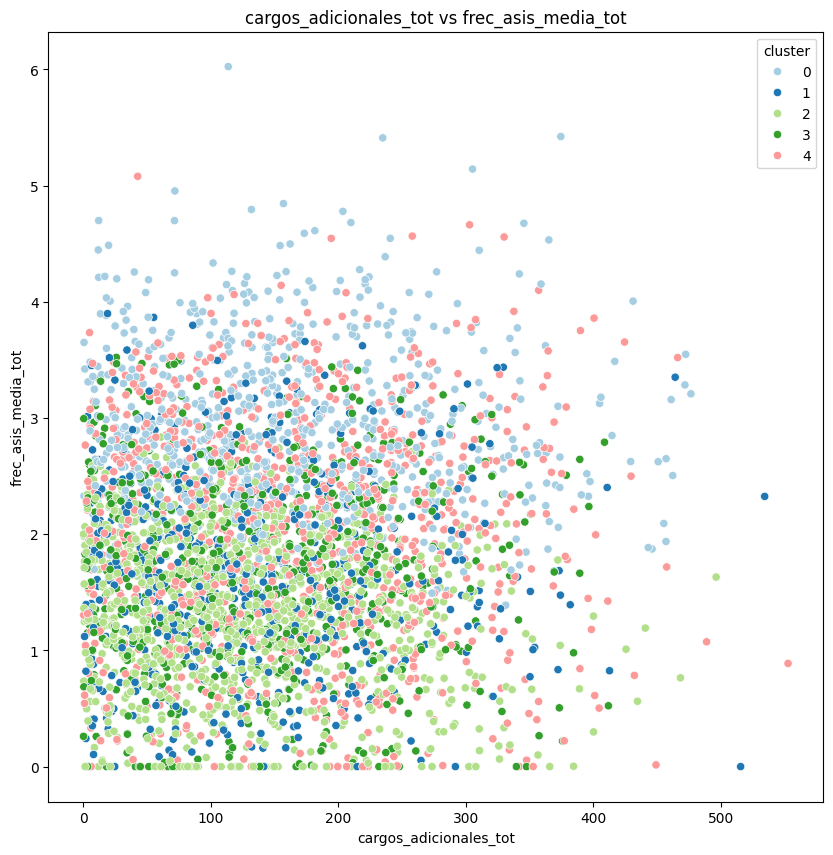

In [57]:
show_clusters_on_plot(data, 'cargos_adicionales_tot', 'frec_asis_media_tot', 'cluster')

Aunque no es fácil distinguir la diferencia entre cada cluster, podemos observar que el comportamiento del cluster 4 (de los que presentan menos cancelaciones) suele asistir más amenudo y por el contrario, el 2 (el que tiene más cancelaciones) tiene una frecuencia de asistencia menor.

Calculemos ahora la tasa de cancelación.

In [59]:
data_suma = data.groupby('cluster').sum()

print("="*137)
for i in range(5):
    total_client = len(data[data['cluster'] == i])
    client_cancel = data_suma['cancelacion'][i]
    tasa_canc = (client_cancel/total_client) * 100
    mensaje = f">>Tasa de cancelación del cluster {i}: {tasa_canc:.2f}%"
    print(mensaje)

>>Tasa de cancelación del cluster 0: 5.99%
>>Tasa de cancelación del cluster 1: 45.20%
>>Tasa de cancelación del cluster 2: 51.24%
>>Tasa de cancelación del cluster 3: 26.77%
>>Tasa de cancelación del cluster 4: 2.23%


Como ya habíamos observado anteriormente, el cluster 0 y 4 son los que mantienen una tasa de cancelación menor y los que mantienen una mayor, son el cluster 1 y 2.

# Conclusión

Muchos de los clientes que cancelan el servicio no tienen la convicción de continuar, sin embargo, si se incentiva a estos mismos clientes a contratar el servicio a plazos mayores se tiene la ventaja de tener un ingreso sin que se deterioren los equipos e instalaciones de los gimnasios.

Se propone realizar un estudio adicional para verificar cuándo se registran más inscripciones al servicio, ya que es probable que haya un aumento después de año nuevo o en algunos meses antes de verano, cuando muchas personas tienen el propósito de bajar de peso o mejorar su aspecto. Identificadas estas fechas se propone enviar promociones para la reinscripción al servicio. Tales promociones pueden incluir reducción de precio a inscripciones proporcionales al tiempo, en otras palabras, a mayor tiempo de servicio contratado, mayor descuento. Los descuentos por referir a un amigo también son viables.

Una vez que el cliente se haya registrado se le debe de dar un plan de desarrollo, esto para fomentarle el hábito del ejercicio y así disminuir la probabilidad de cancelación. Este plan de desarrollo debe informar al cliente lo que necesita para alcanzar su objetivo (la forma de instrucción debe ser valorada, ya que a mayor personalización mejores resultados pero mayores gastos). Se recomienda que este plan deba tener el tiempo de interacción óptimo para crear el hábito (según la University College se necesitan 66 días), así como también los tipos de ejercicios necesarios, la información de la alimentación y una valoración médica.

Se propone también incorporar un descuento temporal en los productos del servicio. Este descuento podría permanecer solo durante el primer mes y/o para cierto número de productos comprados, así como también, reconocimientos y/o recompensas al asistir al menos dos veces por semana de manera consecutiva al gimnasio, para ello se recomienda el uso de una app para gamificar el proceso, aunque esta última tendrá que ser valorada de acuerdo a los resultados después de haber implementado las las recomendaciones anteriores si no se cuenta con el presupuesto necesario para su desarrollo.